# Flower Type Classification Using Transfer Learning
In this notebook, we compare prediction performances of InceptionResNetV2, VGG16, MobileNetV2 and ResNet50V2 image classification pre-trained models in classifying 5 types of flowers.

## Importing Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
#import matplotlib.image as mpimg
import seaborn as sns
#from tqdm.notebook  import tqdm
#import  time
import os
import pathlib 
#import itertools
import shutil
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import keras
!pip install keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from keras.models import Sequential   
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
#from keras.regularizers import l2
#import cv2
from keras.applications import VGG16, ResNet50V2, InceptionV3, InceptionResNetV2, MobileNetV2, EfficientNetB0, EfficientNetB5, EfficientNetV2B0
#from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [10]:
# Generate flower image file paths from the source (Kaggle Dataset Database) with their labels and store into a dataframe
parent_folder = '/kaggle/input/5-flower-types-classification-dataset/flower_images'
file_paths = []
flower_labels = []
flower_folders = os.listdir(parent_folder)
for folder in flower_folders:
    folder_path = os.path.join(parent_folder, folder)
    filenames_list = os.listdir(folder_path)
    for file in filenames_list:
        filename_path = os.path.join(folder_path, file)
        file_paths.append(filename_path)
        flower_labels.append(folder)
# Concatenate image paths with labels into one dataframe
df_files = pd.DataFrame(file_paths, columns= ['Image_Name'])
df_labels = pd.DataFrame(flower_labels, columns=['Label'])
df = pd.concat([df_files, df_labels], axis= 1)
print('Flower Categories: ', flower_folders)

Flower Categories:  ['Orchid', 'Sunflower', 'Tulip', 'Lotus', 'Lilly']


In [11]:
df

Image_Name   Label
0     /kaggle/input/5-flower-types-classification-da...  Orchid
1     /kaggle/input/5-flower-types-classification-da...  Orchid
2     /kaggle/input/5-flower-types-classification-da...  Orchid
3     /kaggle/input/5-flower-types-classification-da...  Orchid
4     /kaggle/input/5-flower-types-classification-da...  Orchid
...                                                 ...     ...
4995  /kaggle/input/5-flower-types-classification-da...   Lilly
4996  /kaggle/input/5-flower-types-classification-da...   Lilly
4997  /kaggle/input/5-flower-types-classification-da...   Lilly
4998  /kaggle/input/5-flower-types-classification-da...   Lilly
4999  /kaggle/input/5-flower-types-classification-da...   Lilly

[5000 rows x 2 columns]

In [12]:
# Display sample image names with their full file name paths
df['Image_Name'][:5].to_list()

['/kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/489cef8f04.jpg',
 '/kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/1d043ac951.jpg',
 '/kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/4587dffd03.jpg',
 '/kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/9b6ae836b2.jpg',
 '/kaggle/input/5-flower-types-classification-dataset/flower_images/Orchid/a59e4c247e.jpg']

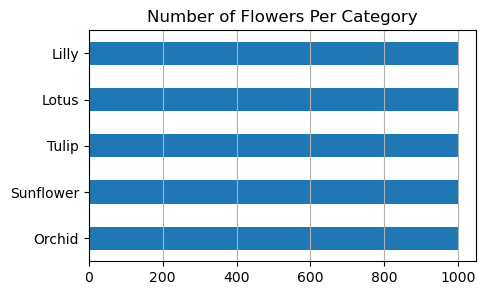

In [13]:
# Checking distribution of flower images per each category
df['Label'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Number of Flowers Per Category', figsize=(5,3)).grid(axis='x')
plt.show()

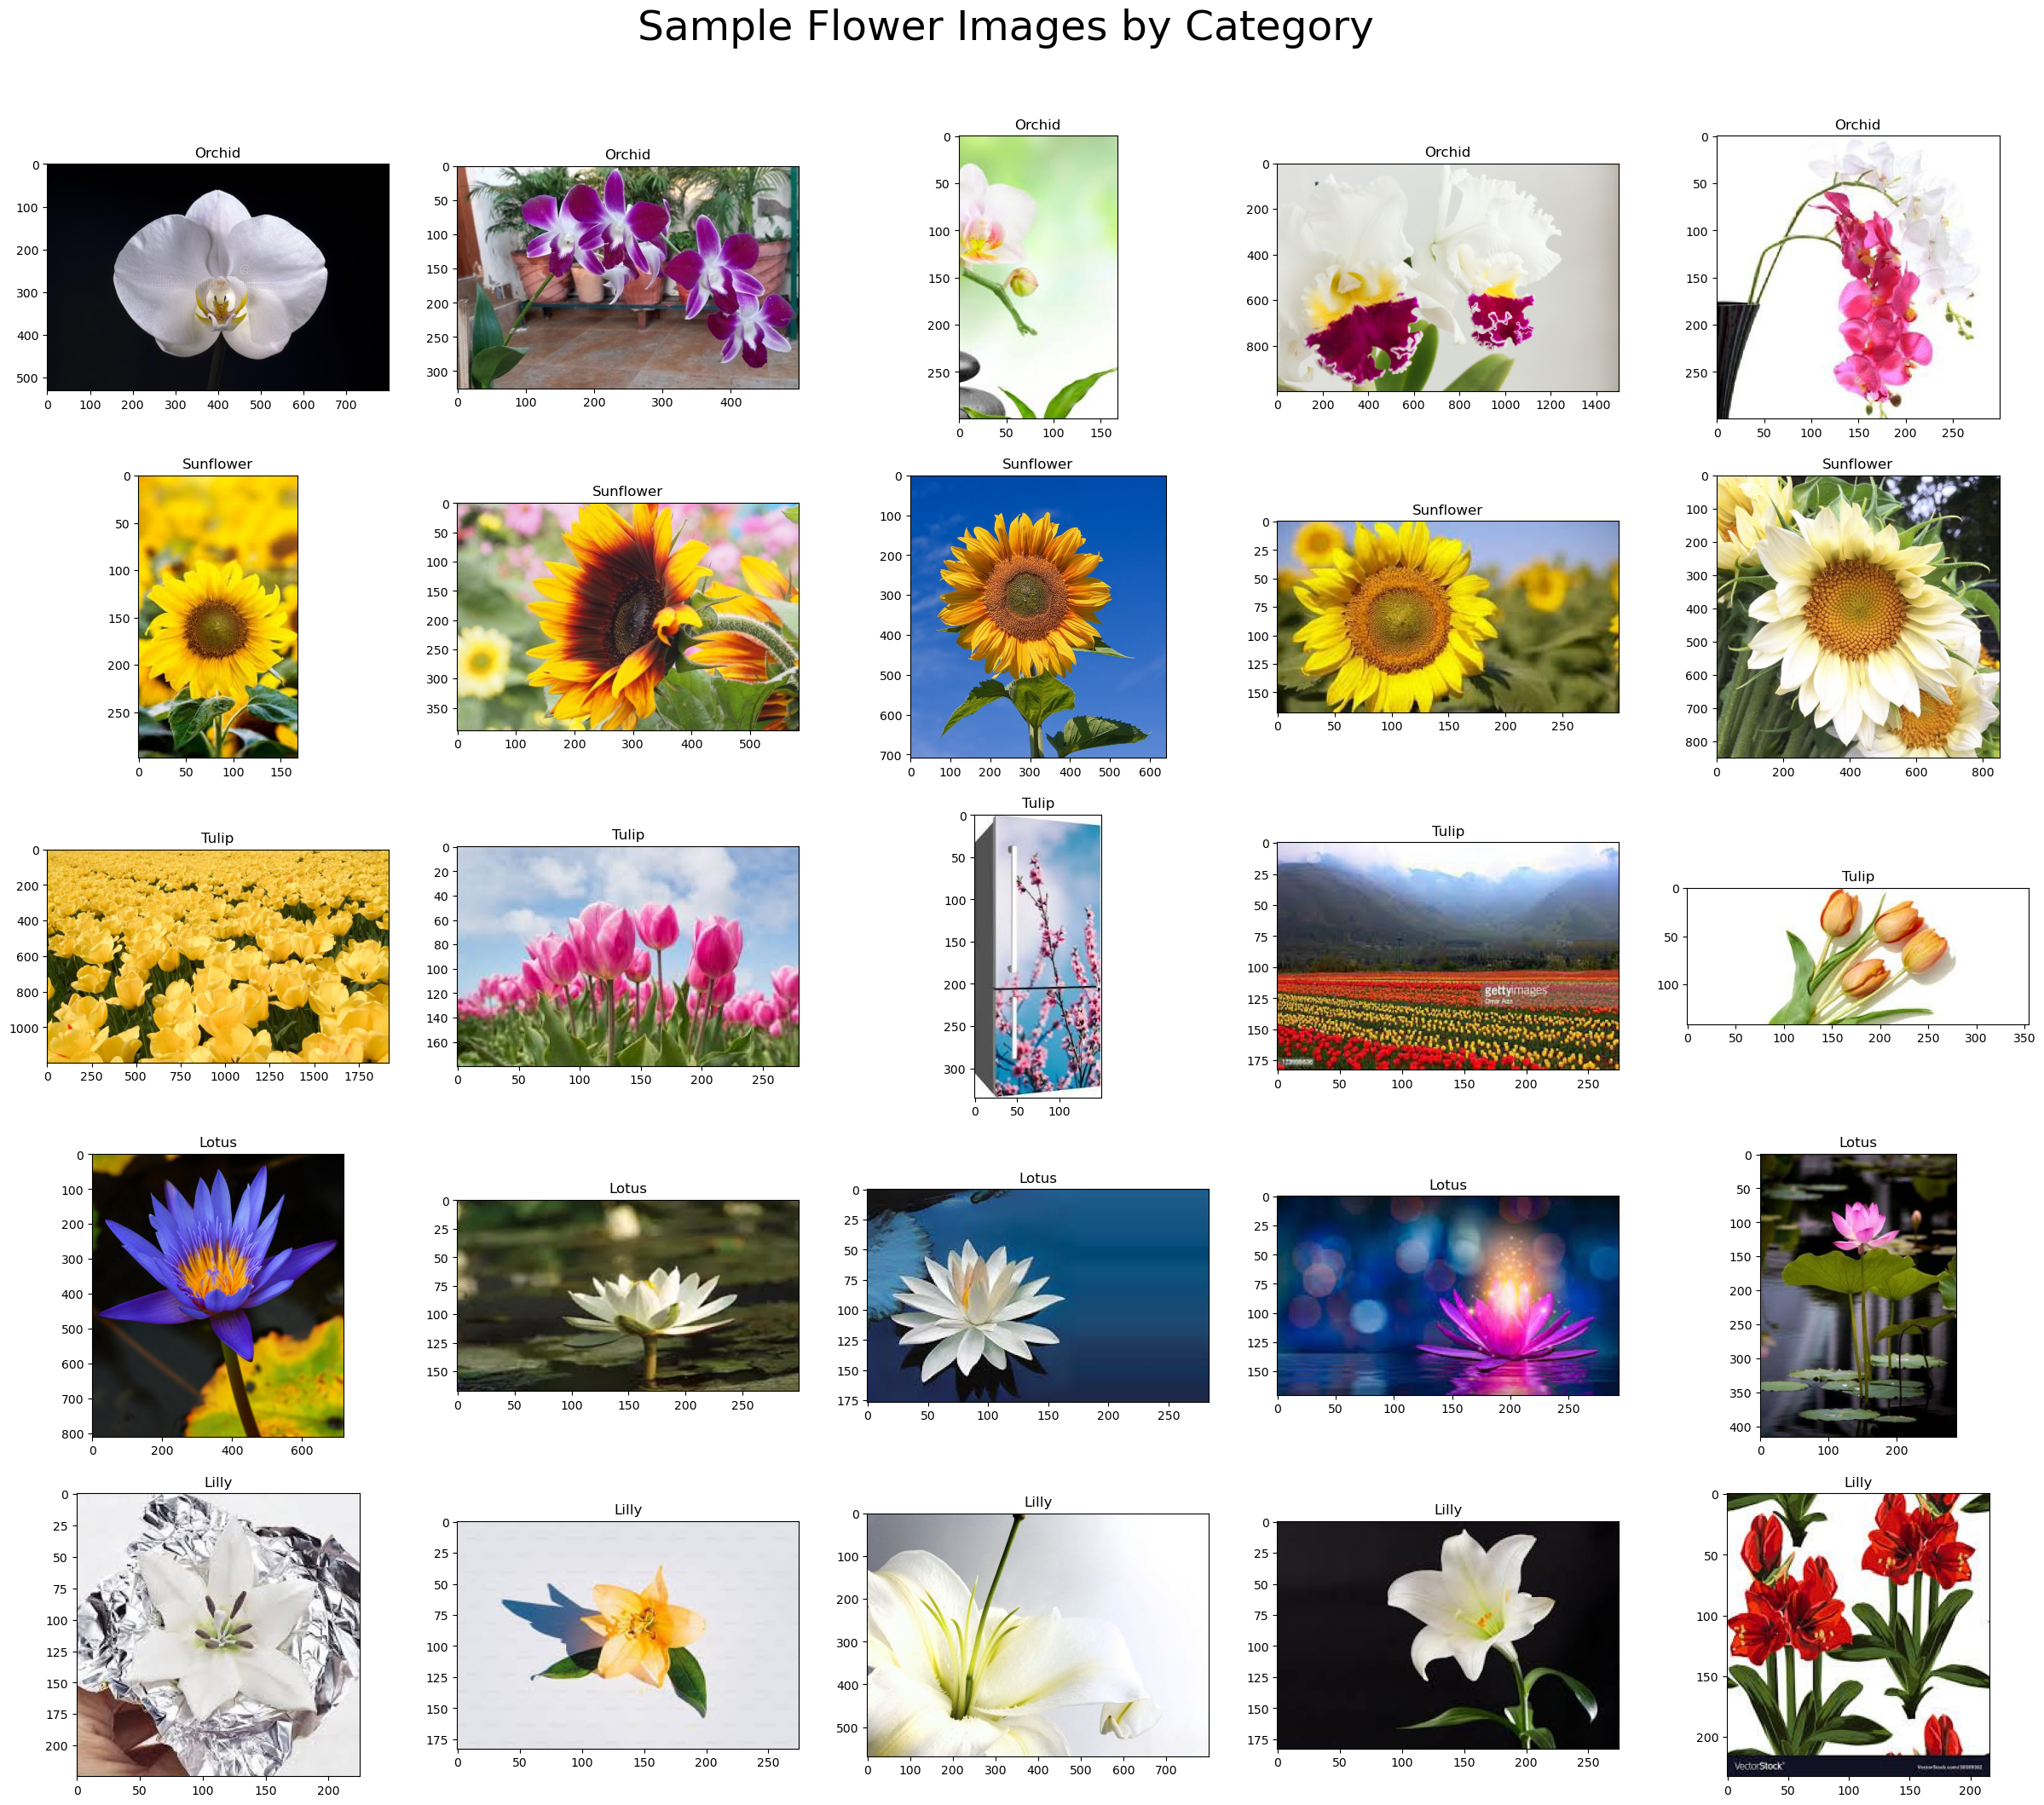

In [14]:
# Plotting sample flowers by their categories
fig, ax = plt.subplots(5,5, figsize=(30,25))
fig.suptitle('Sample Flower Images by Category',fontsize=35, y=0.94)
i = 0
for folder in flower_folders:
    j = 0
    file_names = df['Image_Name'][df['Label'] == folder].to_list()  # get all flower images of the same category
    for file in random.choices(file_names, k=5):  # randomly select 5 images
        image = img.imread(file)
        ax[i, j].imshow(image)
        ax[i, j].set_title(folder)
        j = j + 1
    i = i + 1

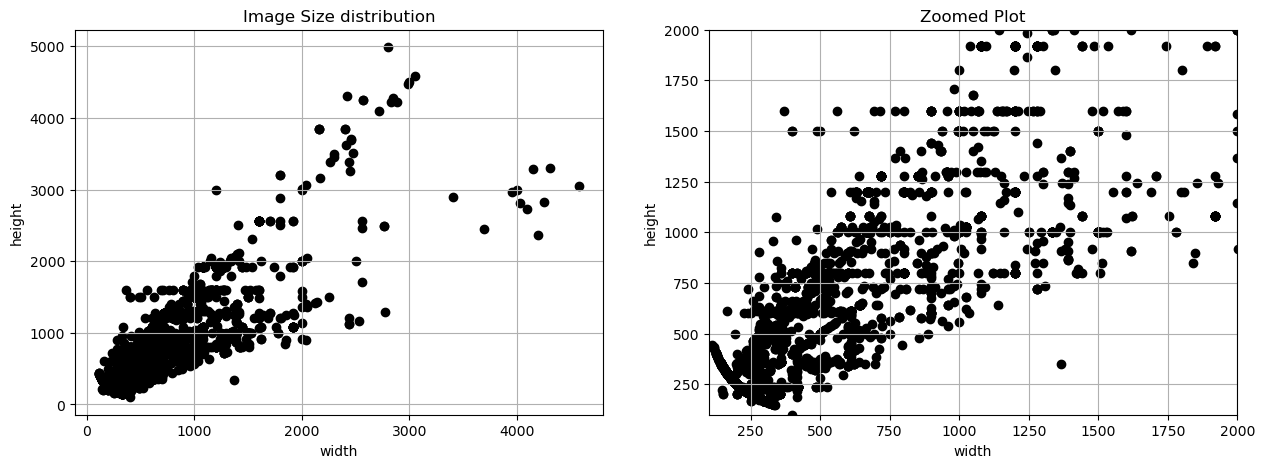

In [15]:
# We need to resize all images to have the same size for efficient learning
# First, we need to understand the distribution of image sizes in terms of width and height
image_list = []
width_list = []
height_list = []
for file_name in file_paths:
    image = img.imread(file_name)   # loaded as numpy array
    image_list.append(image)
    # get width and height of the image and append in a list
    width = image.shape[0]
    height = image.shape[1]
    width_list.append(width)
    height_list.append(height)
    
# plot the distribution of image size 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
## all
ax[0].scatter(x=width_list, y=height_list, color="black")
ax[0].set(xlabel='width', ylabel="height", title="Image Size distribution")
ax[0].grid()

## zoom
ax[1].scatter(x=width_list, y=height_list, color="black")
ax[1].set(xlabel='width', ylabel="height", xlim=[100,2000], ylim=[100,2000], title="Zoomed Plot")
ax[1].grid()
plt.show()

In [16]:
# Deleting unwanted data to free up the memory
del file_names
del image_list
del width_list
del height_list
gc.collect()

161476

## Data Splitting and Pre-processing

In [17]:
# Spitting data into train and test datasets with the same ratio of flower categories
df_train, df_test = train_test_split(df, train_size=0.8, stratify=df['Label'], shuffle=True, random_state=123)

In [18]:
# Defining specifications for image augmentation
train_gen = ImageDataGenerator( rescale=1./255,
                                rotation_range=10,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=False,
                                zoom_range=0.25,
                                shear_range=0.1,
                                brightness_range=[0.2, 1.2],
                                fill_mode='nearest'
                                )
test_gen = ImageDataGenerator(rescale=1./255)

In [19]:
# Defining common parameters for the learning task
batch_size = 16
img_size = (229, 229)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 50

In [20]:
# Defining a function to create train and test datasets by combining dataframe data and images from the folders
def get_dataset(df_train, df_test, img_size, batch_size):
    train_data = train_gen.flow_from_dataframe(df_train, x_col='Image_Name', y_col='Label', target_size=img_size, seed = 42,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

    test_data = test_gen.flow_from_dataframe(df_test, x_col='Image_Name', y_col='Label', target_size=img_size, seed = 42,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    return train_data, test_data

In [21]:
train_data, test_data = get_dataset(df_train, df_test, img_size, batch_size)

Found 4000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


In [22]:
# Get the train and test labels and their encodings
y_train = train_data.classes
y_test = test_data.classes
print('Number of training images: ', len(y_train))
print('Number of testing images: ', len(y_test))
class_dict = train_data.class_indices 
class_labels = list(train_data.class_indices.keys()) 
number_classes = len(class_labels)
print('Class Mapping: ', class_dict)

Number of training images:  4000
Number of testing images:  1000
Class Mapping:  {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}


In [23]:
# Initializing a list to store performance results of all the models trained below
models_results_list = []

## Baseline CNN

In [24]:
# Defining the network architecture
model_cnn = Sequential()
model_cnn.add(Conv2D(512,(3,3), activation='relu', kernel_initializer='uniform', input_shape=img_shape))
model_cnn.add(MaxPooling2D(pool_size=(3,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(512,(3,3), activation='relu', kernel_initializer='uniform'))
model_cnn.add(MaxPooling2D(pool_size=(3,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten()) 
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(number_classes, activation='softmax')) 
model_cnn.summary()
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 512)     14336     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 512)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 512)      2048      
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 512)       2359808   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 512)      0         
 2D)                                                             
                                                        

In [25]:
history = model_cnn.fit(x=train_data, epochs=epochs, verbose=1, validation_data=test_data, 
                    validation_steps=None, shuffle=False,
                   callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5))

Epoch 1/50
250/250 [==============================] - 87s 309ms/step - loss: 5.0265 - accuracy: 0.3862 - val_loss: 1.4165 - val_accuracy: 0.4120
Epoch 2/50
250/250 [==============================] - 75s 299ms/step - loss: 1.3704 - accuracy: 0.4638 - val_loss: 1.1634 - val_accuracy: 0.5380
Epoch 3/50
250/250 [==============================] - 76s 303ms/step - loss: 1.2628 - accuracy: 0.5050 - val_loss: 1.1373 - val_accuracy: 0.5610
Epoch 4/50
250/250 [==============================] - 75s 300ms/step - loss: 1.2276 - accuracy: 0.5160 - val_loss: 1.0966 - val_accuracy: 0.5950
Epoch 5/50
250/250 [==============================] - 74s 298ms/step - loss: 1.2156 - accuracy: 0.5357 - val_loss: 1.1645 - val_accuracy: 0.5910
Epoch 6/50
250/250 [==============================] - 76s 304ms/step - loss: 1.2000 - accuracy: 0.5418 - val_loss: 1.0821 - val_accuracy: 0.5940
Epoch 7/50
250/250 [==============================] - 75s 299ms/step - loss: 1.1678 - accuracy: 0.5520 - val_loss: 1.0670 - val_ac

In [26]:
# Defining a function to plot accuracy and loss performances across all epochs
def plot_loss_accuracy(model):
    # plotting loss and accuracy rates for all epochs
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    axes[0].plot(model.history.history['loss'], 'o-')
    axes[0].plot(model.history.history['val_loss'], 'x-')
    axes[0].legend(['Train Loss', 'Validation Loss'], loc='best', prop={'size':9})
    axes[0].set_title('Training & Validation Losses per Epoch', pad=12)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[1].plot(model.history.history['accuracy'], 'o-')
    axes[1].plot(model.history.history['val_accuracy'], 'x-')
    axes[1].legend(['Train Accuracy', 'Validation Accuracy'], loc='best', prop={'size':9})
    axes[1].set_title('Training & Validation Accuracy per Epoch', pad=12)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    plt.subplots_adjust(wspace=0.2)  # adjusting width spacing between subplots
    plt.show()

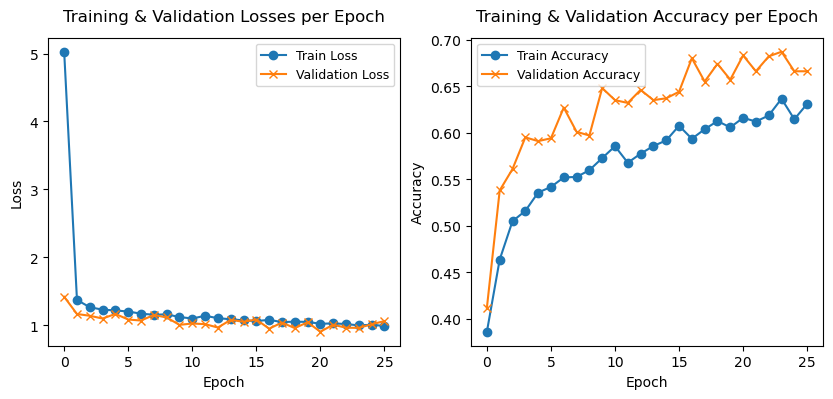

In [27]:
plot_loss_accuracy(model_cnn)

In [28]:
# Model evaluation on test data
y_pred_prob = model_cnn.predict(test_data)
# Convert y values in probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1) 

63/63 [==============================] - 4s 58ms/step


In [29]:
# Defining a function to plot ROC curves and precision_recall curves and confusion matrix, and printing classification report
def print_results(y_test, y_pred, y_pred_prob):
    # plot ROC curves
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    ## Plot ROC curves
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], y_pred_prob[:,i])
        ax[0].plot(fpr, tpr, lw=2, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", 
              title="Receiver Operating Characteristic")
    ax[0].legend(loc="best", labels=class_labels, prop={'size':9})
    ax[0].grid(True)
    
    # plot precision_recall curves
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], y_pred_prob[:,i])
        ax[1].plot(recall, precision, lw=2, label='{0} (area={1:0.2f})'.format(classes[i], 
                                                                               metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall Curve")
    ax[1].legend(loc="best", labels=class_labels, prop={'size':9})
    ax[1].grid(True)
    plt.show()
    print('\n')
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)
    plt.figure(figsize=(5,4))
    hmap = sns.heatmap(df_cm, annot=True, fmt="d", linecolor="purple", linewidths = 0.5)
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('Actuals')
    plt.xlabel('Predictions')
    plt.title('Confusion Matrix')
    plt.show() 

    # print classification report
    print('\n\n')
    print(classification_report(y_test, y_pred, target_names=class_labels))
    report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    #print(report)
    return report

In [30]:
# Defining a function to print out prediction performances
def get_performance(report):
    accuracy = report['accuracy']
    precision =  report['macro avg']['precision'] 
    recall = report['macro avg']['recall']    
    f1 = report['macro avg']['f1-score']
    return accuracy, precision, recall, f1

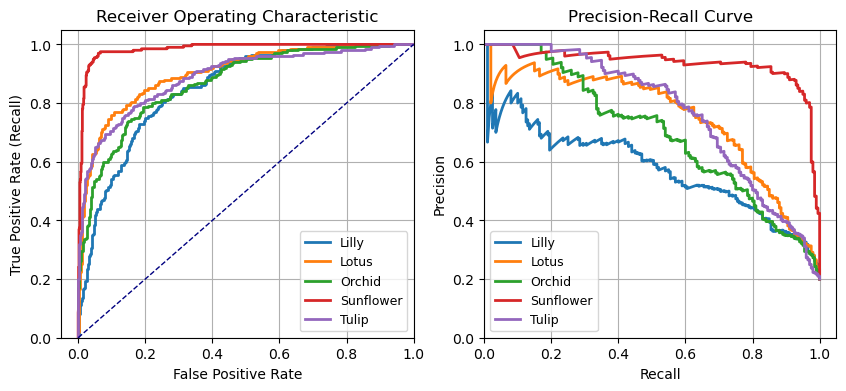

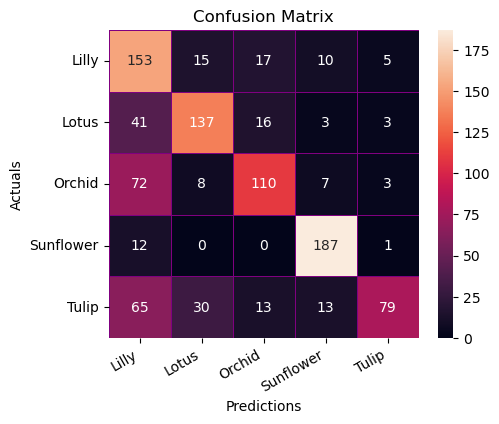




              precision    recall  f1-score   support

       Lilly       0.45      0.77      0.56       200
       Lotus       0.72      0.69      0.70       200
      Orchid       0.71      0.55      0.62       200
   Sunflower       0.85      0.94      0.89       200
       Tulip       0.87      0.40      0.54       200

    accuracy                           0.67      1000
   macro avg       0.72      0.67      0.66      1000
weighted avg       0.72      0.67      0.66      1000



In [31]:
# Display the model's results
report = print_results(y_test, y_pred, y_pred_prob)
accuracy, precision, recall, f1 = get_performance(report)

In [32]:
model_name = 'Baseline CNN'
model = model_cnn
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":round(accuracy,3), "Precision":round(precision,3), "Recall":round(recall,3),"f1":round(f1,3)}, index=[model_name])
models_results_list.append(df_model_results)

## InceptionResNetV2

In [33]:
# Defining the base network component (feature extractor) of the pre-trained InceptionResNetV2
base_inceptionResNetV2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=img_shape)
# next we freeze the base layers of the model from being trained, thus we use their pre-trained weights
# model's trainable weights will not be updated during fit()
base_inceptionResNetV2.trainable = False

219055592/219055592 [==============================] - 2s 0us/step


In [34]:
# Defining the network architecture
model_inceptionResNetV2 = Sequential()
model_inceptionResNetV2.add(base_inceptionResNetV2)
model_inceptionResNetV2.add(BatchNormalization())
model_inceptionResNetV2.add(GlobalAveragePooling2D())
# customizing the classification layer
model_inceptionResNetV2.add(Flatten())
model_inceptionResNetV2.add(Dense(2048, activation='relu'))
model_inceptionResNetV2.add(Dropout(0.3))
model_inceptionResNetV2.add(Dense(number_classes, activation='softmax'))
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_inceptionResNetV2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [35]:
history = model_inceptionResNetV2.fit(x=train_data, epochs=epochs, verbose=1, validation_data=test_data, 
                    validation_steps=None, shuffle=False,
                   callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5))

Epoch 1/50
250/250 [==============================] - 89s 311ms/step - loss: 1.0422 - accuracy: 0.6047 - val_loss: 0.7259 - val_accuracy: 0.7550
Epoch 2/50
250/250 [==============================] - 73s 290ms/step - loss: 0.7450 - accuracy: 0.7322 - val_loss: 0.5985 - val_accuracy: 0.7940
Epoch 3/50
250/250 [==============================] - 73s 291ms/step - loss: 0.6639 - accuracy: 0.7567 - val_loss: 0.5459 - val_accuracy: 0.8090
Epoch 4/50
250/250 [==============================] - 73s 292ms/step - loss: 0.5999 - accuracy: 0.7897 - val_loss: 0.5131 - val_accuracy: 0.8160
Epoch 5/50
250/250 [==============================] - 73s 292ms/step - loss: 0.5641 - accuracy: 0.8023 - val_loss: 0.4866 - val_accuracy: 0.8320
Epoch 6/50
250/250 [==============================] - 73s 292ms/step - loss: 0.5410 - accuracy: 0.8012 - val_loss: 0.4652 - val_accuracy: 0.8400
Epoch 7/50
250/250 [==============================] - 73s 292ms/step - loss: 0.5323 - accuracy: 0.8112 - val_loss: 0.4438 - val_ac

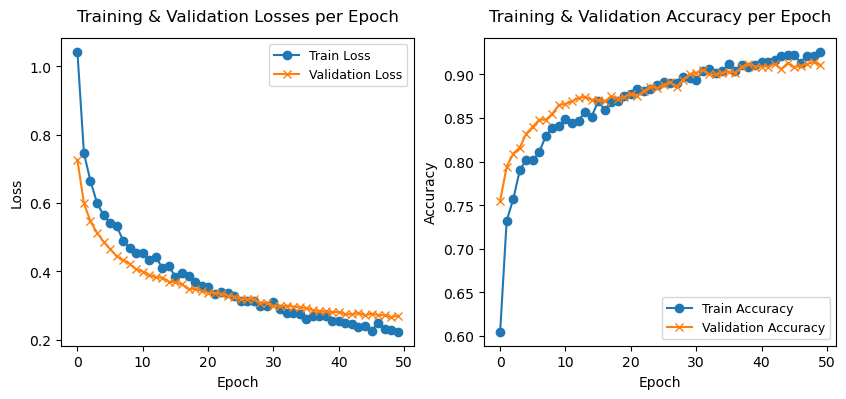

In [36]:
plot_loss_accuracy(model_inceptionResNetV2)

In [37]:
# Model evaluation on test data
y_pred_prob = model_inceptionResNetV2.predict(test_data)
# Convert y values in probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1) 

63/63 [==============================] - 8s 73ms/step


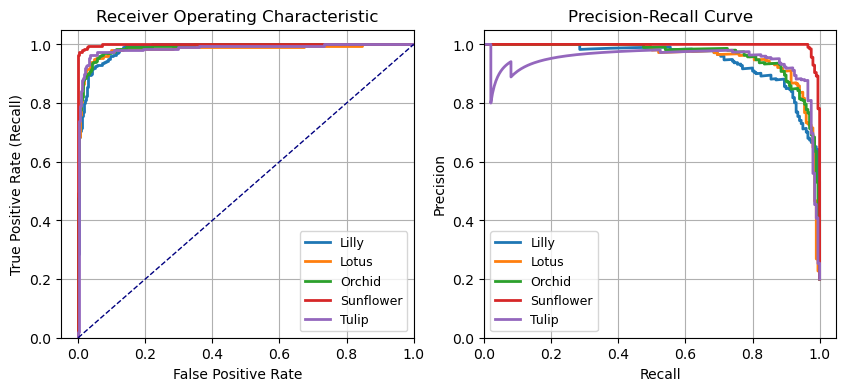

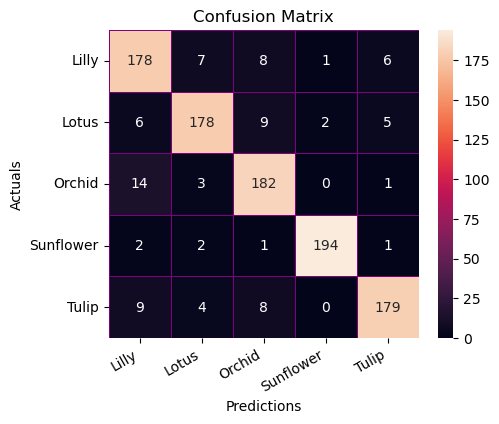




              precision    recall  f1-score   support

       Lilly       0.85      0.89      0.87       200
       Lotus       0.92      0.89      0.90       200
      Orchid       0.88      0.91      0.89       200
   Sunflower       0.98      0.97      0.98       200
       Tulip       0.93      0.90      0.91       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [38]:
# Display model's results
report = print_results(y_test, y_pred, y_pred_prob)
accuracy, precision, recall, f1 = get_performance(report)

In [39]:
model_name = 'InceptionResNetV2'
model = model_inceptionResNetV2
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":round(accuracy,3), "Precision":round(precision,3), "Recall":round(recall,3),"f1":round(f1,3)}, index=[model_name])
models_results_list.append(df_model_results)

In [51]:
# Updating image size to a new dimension that was originally used in training the next models
img_size = (224, 224)
# Get new set of train and test datasets
train_data, test_data = get_dataset(df_train, df_test, img_size, batch_size)

Found 4000 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


## VGG16

In [52]:
# Defining the base network component (feature extractor) of the pre-trained VGG16
base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=img_shape)
base_vgg16.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [53]:
# Defining the network architecture
model_vgg16 = Sequential()
model_vgg16.add(base_vgg16)
model_vgg16.add(BatchNormalization())
model_vgg16.add(GlobalAveragePooling2D())
# customizing the classification layer
model_vgg16.add(Flatten())
model_vgg16.add(Dense(2048, activation='relu'))
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(number_classes, activation='softmax'))
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_vgg16.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [54]:
history = model_vgg16.fit(x=train_data, epochs=epochs, verbose=1, validation_data=test_data, 
                    validation_steps=None, shuffle=False,
                   callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5))

Epoch 1/50
250/250 [==============================] - 69s 267ms/step - loss: 1.4474 - accuracy: 0.4313 - val_loss: 1.3013 - val_accuracy: 0.6140
Epoch 2/50
250/250 [==============================] - 66s 263ms/step - loss: 1.2167 - accuracy: 0.5810 - val_loss: 1.0161 - val_accuracy: 0.6880
Epoch 3/50
250/250 [==============================] - 66s 264ms/step - loss: 1.0971 - accuracy: 0.6160 - val_loss: 0.8888 - val_accuracy: 0.7030
Epoch 4/50
250/250 [==============================] - 66s 263ms/step - loss: 1.0287 - accuracy: 0.6407 - val_loss: 0.8250 - val_accuracy: 0.7110
Epoch 5/50
250/250 [==============================] - 66s 265ms/step - loss: 0.9733 - accuracy: 0.6595 - val_loss: 0.7782 - val_accuracy: 0.7260
Epoch 6/50
250/250 [==============================] - 66s 265ms/step - loss: 0.9247 - accuracy: 0.6770 - val_loss: 0.7368 - val_accuracy: 0.7330
Epoch 7/50
250/250 [==============================] - 66s 263ms/step - loss: 0.8941 - accuracy: 0.6773 - val_loss: 0.7106 - val_ac

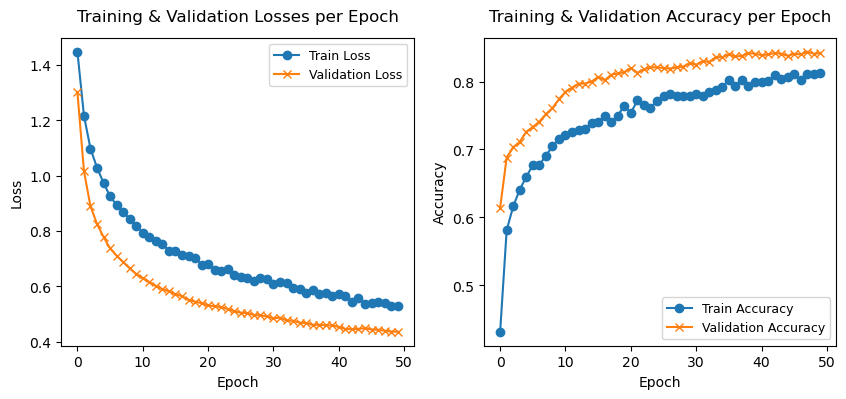

In [55]:
plot_loss_accuracy(model_vgg16)

In [56]:
# Model evaluation on test data
y_pred_prob = model_vgg16.predict(test_data)
# Convert y values in probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1) 

63/63 [==============================] - 4s 56ms/step


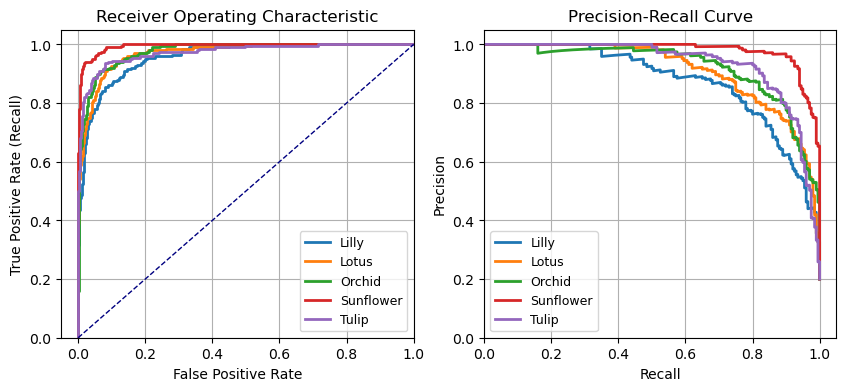

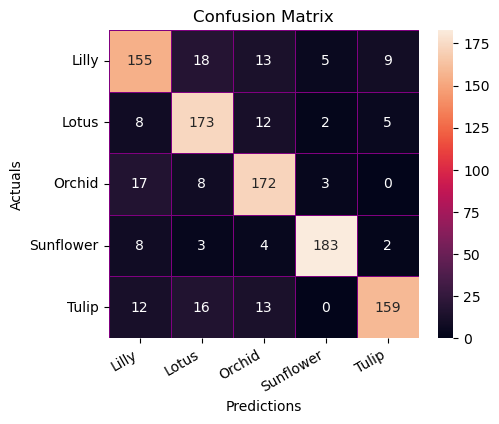




              precision    recall  f1-score   support

       Lilly       0.78      0.78      0.78       200
       Lotus       0.79      0.86      0.83       200
      Orchid       0.80      0.86      0.83       200
   Sunflower       0.95      0.92      0.93       200
       Tulip       0.91      0.80      0.85       200

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000



In [57]:
# Display model's results
report = print_results(y_test, y_pred, y_pred_prob)
accuracy, precision, recall, f1 = get_performance(report)

In [58]:
model_name = 'VGG16'
model = model_vgg16
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":round(accuracy,3), "Precision":round(precision,3), "Recall":round(recall,3),"f1":round(f1,3)}, index=[model_name])
models_results_list.append(df_model_results)

## MobileNetV2

In [59]:
# Defining the base network component (feature extractor) of the pre-trained MobileNetV2
base_mobilenetv2 = MobileNetV2(include_top=False, weights='imagenet', input_shape=img_shape)
base_mobilenetv2.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [60]:
# Defining the network architecture
model_mobilenetv2 = Sequential()
model_mobilenetv2.add(base_mobilenetv2)
model_mobilenetv2.add(BatchNormalization())
model_mobilenetv2.add(GlobalAveragePooling2D())
# customizing the classification layer
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(2048, activation='relu'))
model_mobilenetv2.add(Dropout(0.3))
model_mobilenetv2.add(Dense(number_classes, activation='softmax'))
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_mobilenetv2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [61]:
history = model_mobilenetv2.fit(x=train_data, epochs=epochs, verbose=1, validation_data=test_data, 
                    validation_steps=None, shuffle=False,
                   callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5))

Epoch 1/50
250/250 [==============================] - 68s 259ms/step - loss: 1.1899 - accuracy: 0.5602 - val_loss: 0.7980 - val_accuracy: 0.7810
Epoch 2/50
250/250 [==============================] - 63s 254ms/step - loss: 0.8380 - accuracy: 0.7285 - val_loss: 0.6171 - val_accuracy: 0.8180
Epoch 3/50
250/250 [==============================] - 63s 253ms/step - loss: 0.7203 - accuracy: 0.7598 - val_loss: 0.5426 - val_accuracy: 0.8350
Epoch 4/50
250/250 [==============================] - 63s 252ms/step - loss: 0.6702 - accuracy: 0.7747 - val_loss: 0.4981 - val_accuracy: 0.8380
Epoch 5/50
250/250 [==============================] - 65s 261ms/step - loss: 0.6223 - accuracy: 0.7865 - val_loss: 0.4692 - val_accuracy: 0.8350
Epoch 6/50
250/250 [==============================] - 63s 254ms/step - loss: 0.5950 - accuracy: 0.7975 - val_loss: 0.4460 - val_accuracy: 0.8420
Epoch 7/50
250/250 [==============================] - 63s 251ms/step - loss: 0.5698 - accuracy: 0.7935 - val_loss: 0.4334 - val_ac

In [62]:
# Model evaluation on test data
y_pred_prob = model_mobilenetv2.predict(test_data)
# Convert y values in probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1) 

63/63 [==============================] - 4s 56ms/step


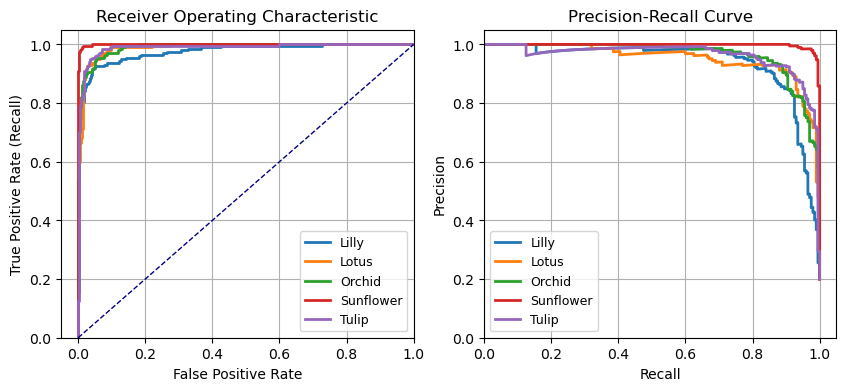

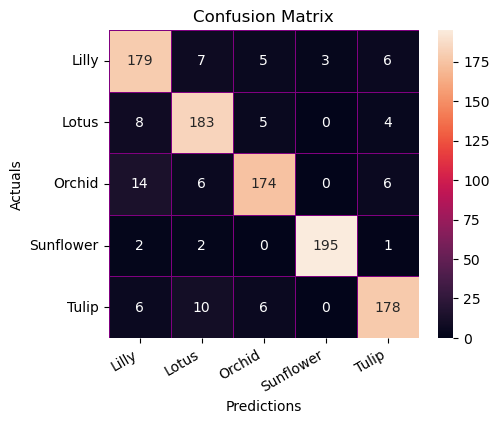




              precision    recall  f1-score   support

       Lilly       0.86      0.90      0.88       200
       Lotus       0.88      0.92      0.90       200
      Orchid       0.92      0.87      0.89       200
   Sunflower       0.98      0.97      0.98       200
       Tulip       0.91      0.89      0.90       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [63]:
# Display the model's results
report = print_results(y_test, y_pred, y_pred_prob)
accuracy, precision, recall, f1 = get_performance(report)

In [64]:
model_name = 'MobileNetV2'
model = model_mobilenetv2
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":round(accuracy,3), "Precision":round(precision,3), "Recall":round(recall,3),"f1":round(f1,3)}, index=[model_name])
models_results_list.append(df_model_results)

## ResNet50V2

In [65]:
# Defining the base network component (feature extractor) of the pre-trained ResNet50V2
base_resnet50v2 = ResNet50V2(include_top=False, weights='imagenet', input_shape=img_shape)
base_resnet50v2.trainable = False

94668760/94668760 [==============================] - 0s 0us/step


In [66]:
# Defining the network architecture
model_resnet50v2 = Sequential()
model_resnet50v2.add(base_resnet50v2)
model_resnet50v2.add(BatchNormalization())
model_resnet50v2.add(GlobalAveragePooling2D())
# customizing the classification layer
model_resnet50v2.add(Flatten())
model_resnet50v2.add(Dense(2048, activation='relu'))
model_resnet50v2.add(Dropout(0.3))
model_resnet50v2.add(Dense(number_classes, activation='softmax'))
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8, nesterov=True)
model_resnet50v2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [67]:
history = model_resnet50v2.fit(x=train_data, epochs=epochs, verbose=1, validation_data=test_data, 
                    validation_steps=None, shuffle=False,
                   callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=5))

Epoch 1/50
250/250 [==============================] - 72s 272ms/step - loss: 1.2499 - accuracy: 0.5567 - val_loss: 0.9352 - val_accuracy: 0.7560
Epoch 2/50
250/250 [==============================] - 65s 261ms/step - loss: 0.8918 - accuracy: 0.7255 - val_loss: 0.7313 - val_accuracy: 0.7900
Epoch 3/50
250/250 [==============================] - 66s 263ms/step - loss: 0.7364 - accuracy: 0.7703 - val_loss: 0.6257 - val_accuracy: 0.8110
Epoch 4/50
250/250 [==============================] - 66s 264ms/step - loss: 0.6583 - accuracy: 0.7870 - val_loss: 0.5668 - val_accuracy: 0.8200
Epoch 5/50
250/250 [==============================] - 67s 267ms/step - loss: 0.6075 - accuracy: 0.8040 - val_loss: 0.5282 - val_accuracy: 0.8290
Epoch 6/50
250/250 [==============================] - 66s 264ms/step - loss: 0.5845 - accuracy: 0.8025 - val_loss: 0.5006 - val_accuracy: 0.8390
Epoch 7/50
250/250 [==============================] - 66s 265ms/step - loss: 0.5380 - accuracy: 0.8185 - val_loss: 0.4789 - val_ac

In [68]:
# Model evaluation on test data
y_pred_prob = model_resnet50v2.predict(test_data)
# Convert y values in probabilities into class labels
y_pred = np.argmax(y_pred_prob, axis=1)  # np.argmax returns the label of the class with the highest probability and since the prediction is on a batch of data rather than a single sample, axis=1 should be used.

63/63 [==============================] - 5s 58ms/step


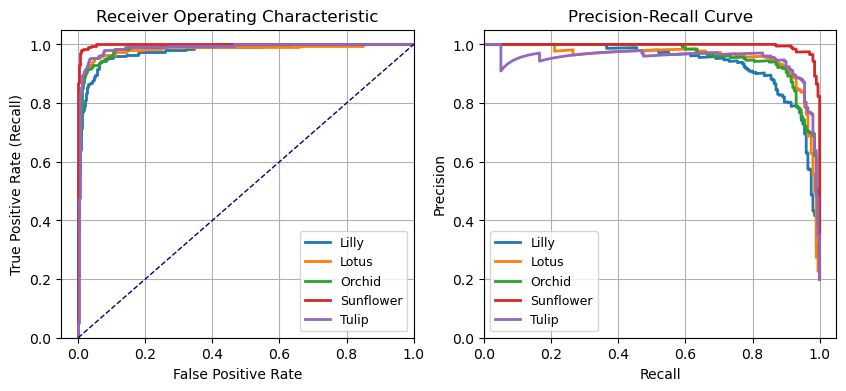

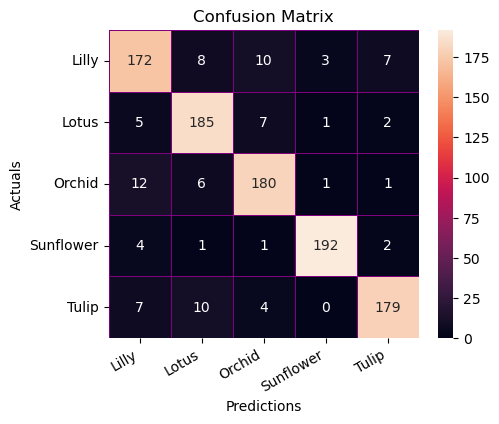




              precision    recall  f1-score   support

       Lilly       0.86      0.86      0.86       200
       Lotus       0.88      0.93      0.90       200
      Orchid       0.89      0.90      0.90       200
   Sunflower       0.97      0.96      0.97       200
       Tulip       0.94      0.90      0.92       200

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [69]:
# Display the model's results
report = print_results(y_test, y_pred, y_pred_prob)
accuracy, precision, recall, f1 = get_performance(report)

In [70]:
model_name = 'ResNet50V2'
model = model_resnet50v2
# creating a dataframe of model's results and append them into the list of dataframes of results of all models
df_model_results = pd.DataFrame({"Accuracy":round(accuracy,3), "Precision":round(precision,3), "Recall":round(recall,3),"f1":round(f1,3)}, index=[model_name])
models_results_list.append(df_model_results)

In [71]:
# Comparing results of all models
df_results = pd.concat(models_results_list, axis=0)  # appending dataframes row-wise
df_results.sort_values(['Accuracy','f1'], ascending=[False, False])
df_results

Accuracy  Precision  Recall     f1
Baseline CNN          0.666      0.718   0.666  0.664
InceptionResNetV2     0.911      0.912   0.911  0.911
VGG16                 0.842      0.846   0.842  0.843
MobileNetV2           0.909      0.910   0.909  0.909
ResNet50V2            0.908      0.909   0.908  0.908

The results above is indicating that the pre-trained models perform well above the baseline CNN in this task. However, there is still a room to improve their performances by further tuning their networks structure. This may include tuning hyperparameters, training some of the layers of the base network and increasing the size of classification layer